In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from numpy import genfromtxt
import os
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("../../../")
from utils.utils import MyDataset, MyDatasetV2, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.vae import VAE
from networks.vae_v2 import VAE_V2
from networks.ccvae import CCVAE
from networks.utils import EarlyStopper
import argparse
from algorithms.GA.utils import write_firewall_file, erase_firebreaks
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall, F1Score, Dice
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score, MeanAbsolutePercentageError
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import random


In [ ]:
# Data Loading
dataset = MyDatasetV2("../../../../data/complete_random/homo_2/")
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))


In [ ]:
# Model Params
params = {}
params["latent_dims"] = 256
params["capacity"] = 128
params["use_gpu"] =  False
params["input_size"] = 20
params["epochs"] = 20
params["sigmoid"] = True
params["lr1"] = 1e-5
params["lr2"] = 1e-5
params["instance"] = "homo_2"
params["not_reduced"] = False
params["variational_beta"] = 0.1
params["distribution_std"] = 0.1
params["latent_portion"] = 0.5
params["alpha"] = 10000

In [ ]:
# Model Instantiation
model = CCVAE(params).to("cpu")
model.eval()

CCVAE(
  (conv1): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6400, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=6400, out_features=256, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (encoder): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inpla

In [27]:
# Load weights
model.load_state_dict(torch.load(f'../../../weights/homo_2/CCVAE/sub20x20_latent=256_capacity=128_100_sigmoid=True_T1=100_T2=100_lr1=1e-05_lr2=1e-05_lr3=0.0001_normalize=False_weight_decay=0_not_reduced=False_variational_beta=0.1_distribution_std=0.2_alpha=100000.0.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [ ]:
def calc_fitness(model, embedding, n_sims = 50):
        """
        Calculates the average number of burned cells of embedding's associated
        solution.
        """
        solution = model.decode(embedding[0])
        _, indices = torch.topk(solution.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        assert(matrix.sum().item() == 20)
        write_firewall_file(matrix * -1.)
        n_weathers = len([i for i in os.listdir("../../../../data/complete_random/homo_2/Sub20x20/Weathers/") if i.endswith('.csv')])-2
        exec_str = f"../../../algorithms/eval/C2F-W/Cell2FireC/Cell2Fire --input-instance-folder ../../../../data/complete_random/homo_2/Sub20x20/ --output-folder ../../../algorithms/eval/results/ --sim-years 1 --nsims {n_sims}--Fire-Period-Length 1.0 --output-messages --ROS-CV 0.0 --seed 123 --weather random --ignitions --IgnitionRad 4 --sim C --final-grid --nweathers {n_weathers} --FirebreakCells ../../../algorithms/eval/harvested/HarvestedCells.csv"
        os.system(exec_str + " >/dev/null 2>&1")
        reward = 0
        base_directory = f"../../../algorithms/eval/results/Grids/Grids"
        for j in range(1, n_sims+1):
            dir = f"{base_directory}{str(j)}/"
            files = os.listdir(dir)
            my_data = genfromtxt(dir+files[-1], delimiter=',')
            # Burned cells are counted and turned into negative rewards
            for cell in my_data.flatten():
                if cell == 1:
                    reward-= 1
        erase_firebreaks()
        return 1 + ((reward/n_sims) / 400)

## Model Fitness

In [ ]:
# Metrics
def binary_accuracy(reconstructed, original):
    correct = (reconstructed == original).sum()
    total = original.numel()  # Total number of elements
    return correct / total
def precision_recall_f1(reconstructed, original):
    tp = ((reconstructed == 1) & (original == 1)).sum()  # True Positives
    fp = ((reconstructed == 1) & (original == 0)).sum()  # False Positives
    fn = ((reconstructed == 0) & (original == 1)).sum()  # False Negatives
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return precision, recall, f1
def dice_coefficient(reconstructed, original):
    intersection = (reconstructed & original).sum()  # Element-wise AND
    dice = (2.0 * intersection) / (reconstructed.sum() + original.sum() + 1e-8)
    return dice
def jaccard_index(reconstructed, original):
    intersection = (reconstructed & original).sum()
    union = (reconstructed | original).sum()
    jaccard = intersection / (union + 1e-8)
    return jaccard


In [39]:
# Initialize metrics
accuracy = Accuracy(task="binary")
precision = Precision(task="binary")
recall = Recall(task="binary")
f1 = F1Score(task="binary")
# Initialize metrics
mse = MeanSquaredError()
mae = MeanAbsoluteError()
r2 = R2Score()
mape = MeanAbsolutePercentageError()

In [ ]:
# Compute metrics for train set
for x, r in tqdm(train_dataset):
    with torch.no_grad():
        recon, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
        _, indices = torch.topk(recon.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        # Update metrics
        accuracy.update(matrix, x[0])
        precision.update(matrix, x[0])
        recall.update(matrix, x[0])
        mse.update(r_[0], r)
        mae.update(r_[0], r)
        r2.update(r_[0], r)
        mape.update(r_[0], r)
# Compute final aggregated metrics
final_accuracy = accuracy.compute()
final_precision = precision.compute()
final_recall = recall.compute()
final_mse = mse.compute()
final_mae = mae.compute()
final_r2 = r2.compute()
final_mape = mape.compute()


print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"MSE: {final_mse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R2: {final_r2:.4f}")
print(f"MAPE: {final_mape:.4f}")

100%|██████████| 45000/45000 [02:56<00:00, 254.51it/s]

Accuracy: 1.0000
Precision: 0.9999
Recall: 0.9999
MSE: 0.0000
MAE: 0.0040
R2: 0.8393
MAPE: 0.0056


In [ ]:
# Compute metrics for validation set
for x, r in tqdm(validation_dataset):
    with torch.no_grad():
        recon, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
        _, indices = torch.topk(recon.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        # Update metrics
        accuracy.update(matrix, x[0])
        precision.update(matrix, x[0])
        recall.update(matrix, x[0])
        mse.update(r_[0], r)
        mae.update(r_[0], r)
        r2.update(r_[0], r)
        mape.update(r_[0], r)
# Compute final aggregated metrics
final_accuracy = accuracy.compute()
final_precision = precision.compute()
final_recall = recall.compute()
final_mse = mse.compute()
final_mae = mae.compute()
final_r2 = r2.compute()
final_mape = mape.compute()


print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"MSE: {final_mse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R2: {final_r2:.4f}")
print(f"MAPE: {final_mape:.4f}")

100%|██████████| 2500/2500 [00:15<00:00, 162.06it/s]

Accuracy: 1.0000
Precision: 0.9998
Recall: 0.9998
MSE: 0.0000
MAE: 0.0042
R2: 0.8329
MAPE: 0.0058


## Latent Space Analysis

In [ ]:
# Get embeddings from 10000 points in train_dataset into a numpy array
embeddings = []
r_ = []
for x, r in tqdm(train_dataset):
    with torch.no_grad():
        z, _ = model.encode(x.unsqueeze(0))
        embeddings.append(z[0].numpy())
        r_.append(r[0])
embeddings = np.array(embeddings)
r_ = np.array(r_)

100%|██████████| 45000/45000 [01:05<00:00, 691.67it/s]


In [ ]:
# Apply UMAP
n = 50000
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings[:n])

/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


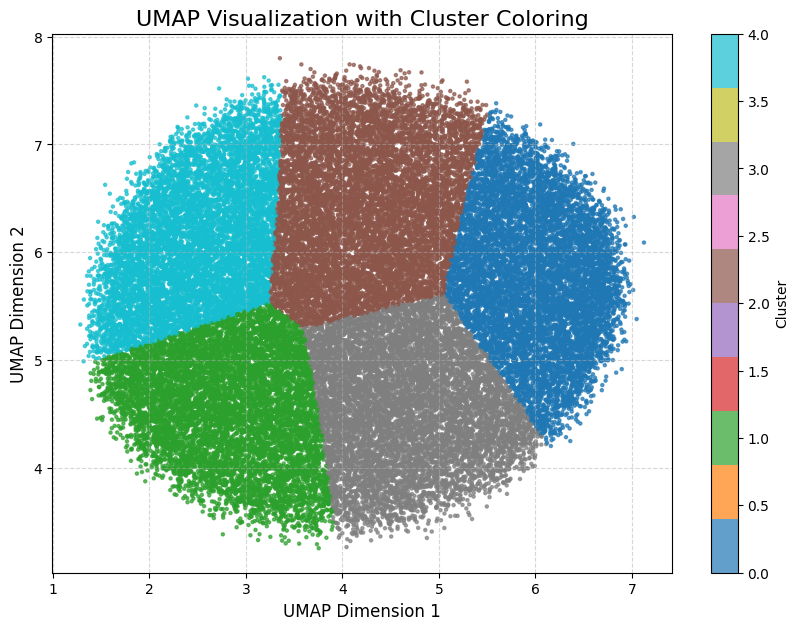

In [ ]:
# Apply GMM
n_components = 5  # Number of clusters to identify
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(embeddings_2d)

# Step 4: Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gmm_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('UMAP Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


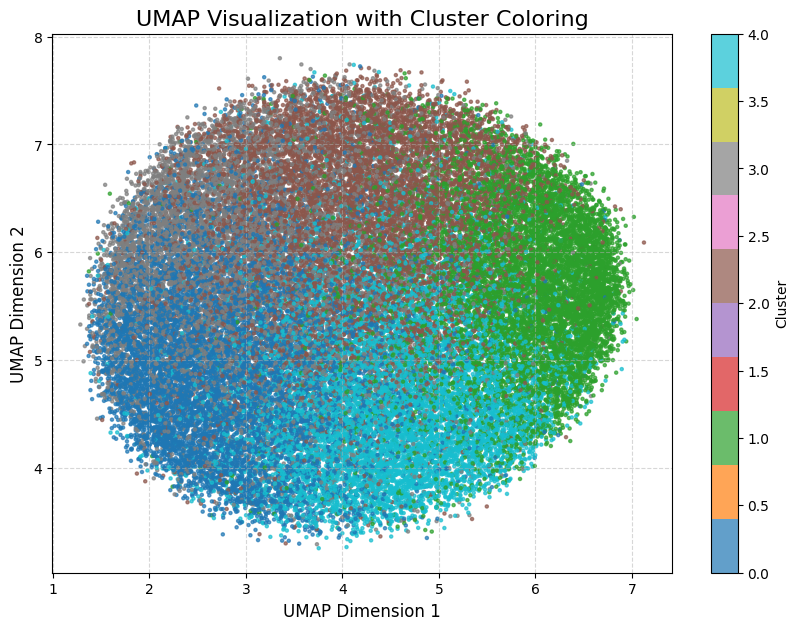

In [ ]:
# Apply K-Means
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings[:n])

# Step 4: Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('UMAP Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

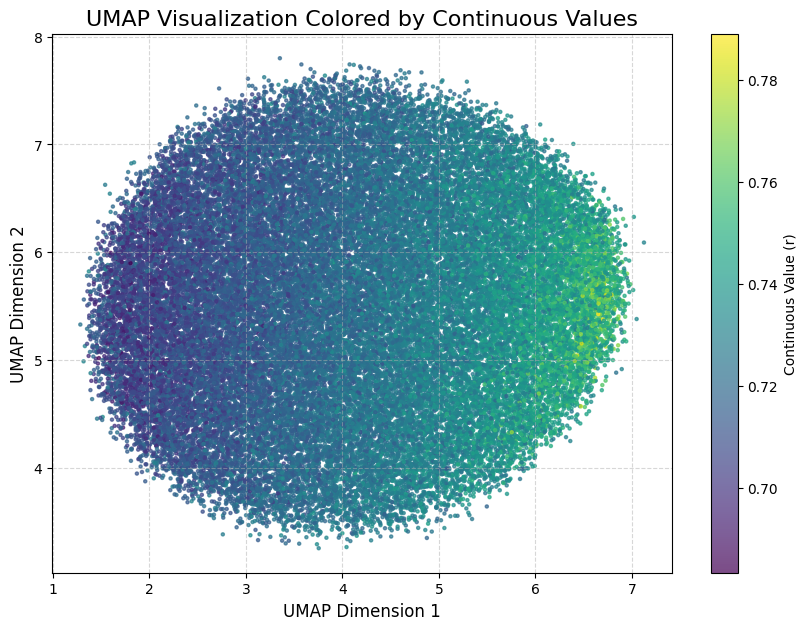

In [ ]:
# Visualize with Continuous Color Mapping, corresponding to fitness
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=r_[:n], cmap='viridis', s=5, alpha=0.7
)
plt.colorbar(scatter, label="Continuous Value (r)")  # Add colorbar for the scale
plt.title('UMAP Visualization Colored by Continuous Values', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


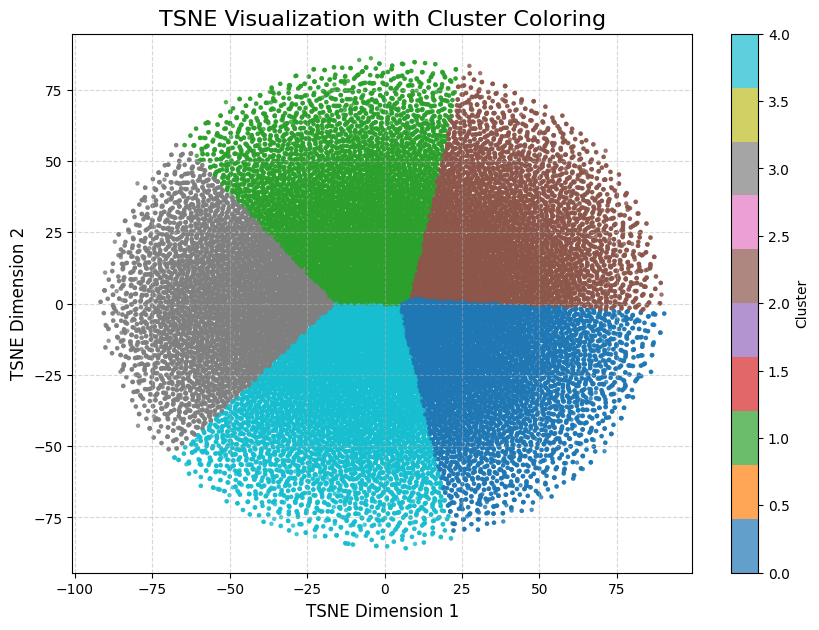

In [ ]:
# Reducing dimensionality using tsne and appy kmeans
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, random_state=42)
n = 50000
embeddings_2d_tsne = tsne.fit_transform(embeddings[:n])
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d_tsne[:n])


# Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('TSNE Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('TSNE Dimension 1', fontsize=12)
plt.ylabel('TSNE Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

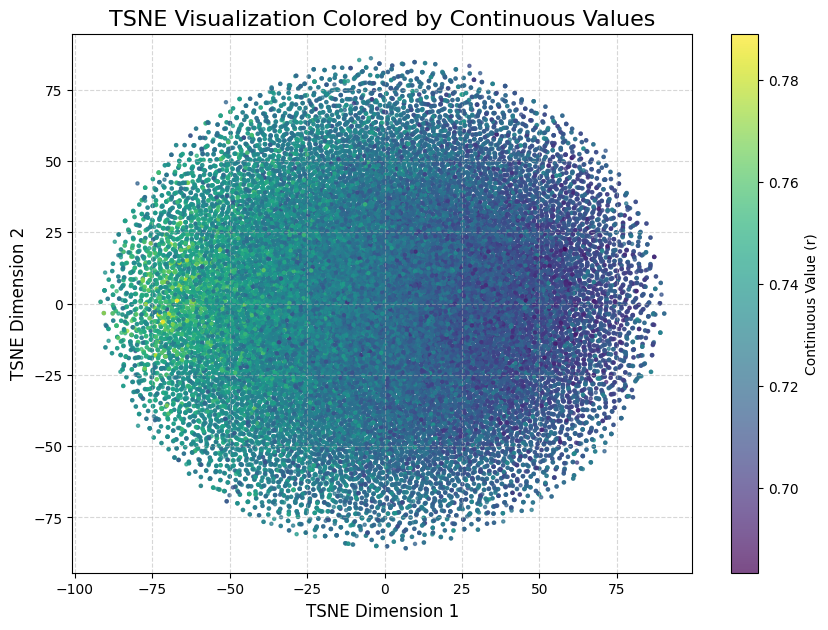

In [ ]:
# Ploting the embeddings colored by the continuous value of fitness using tsne
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=r_[:n], cmap='viridis', s=5, alpha=0.7)
plt.colorbar(scatter, label="Continuous Value (r)")  # Add colorbar for the scale
plt.title('TSNE Visualization Colored by Continuous Values', fontsize=16)
plt.xlabel('TSNE Dimension 1', fontsize=12)
plt.ylabel('TSNE Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


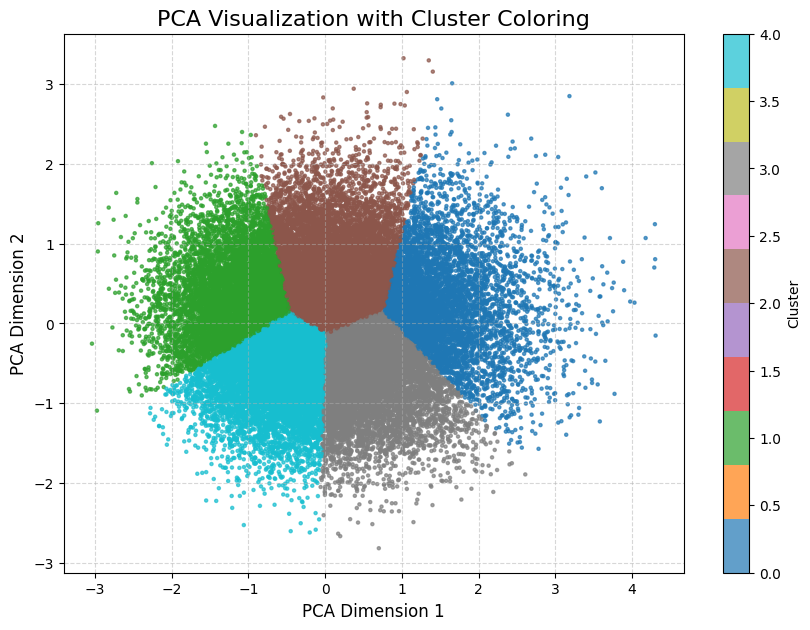

In [108]:
# Apply PCA to embbedings
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings[:n])
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d_pca[:n])

# Step 4: Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('PCA Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('PCA Dimension 1', fontsize=12)
plt.ylabel('PCA Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

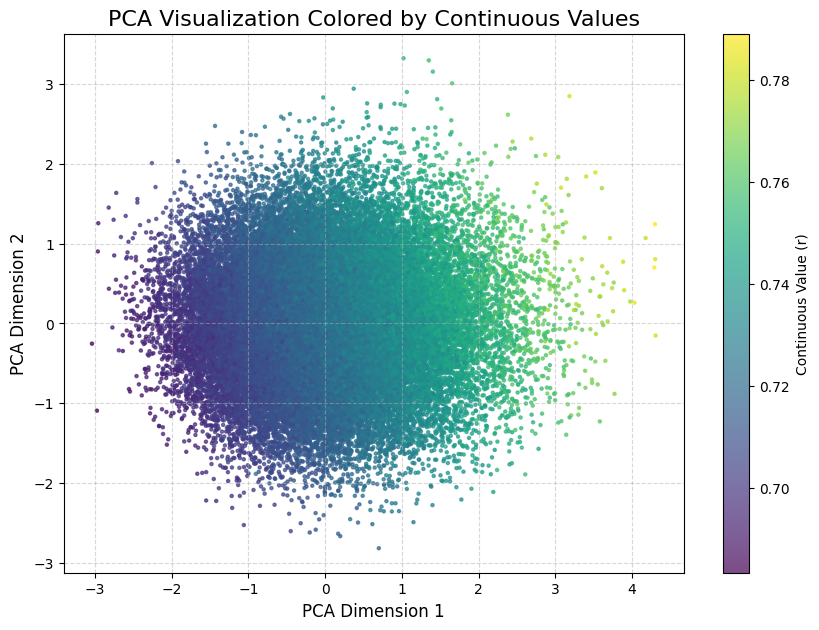

In [ ]:
# Color by continuous value r
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], c=r_[:n], cmap='viridis', s=5, alpha=0.7)
plt.colorbar(scatter, label="Continuous Value (r)")  # Add colorbar for the scale
plt.title('PCA Visualization Colored by Continuous Values', fontsize=16)
plt.xlabel('PCA Dimension 1', fontsize=12)
plt.ylabel('PCA Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Interpolation

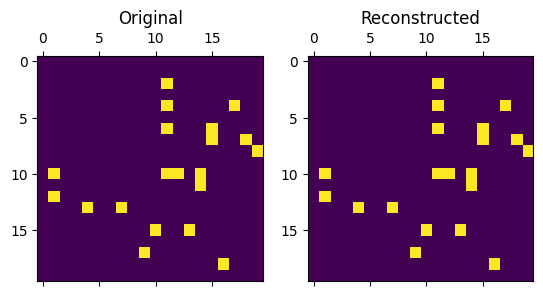

In [ ]:
x, r = dataset[1]
recon, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
# Plotting the original binary matrix
plt.subplot(1, 2, 1)
plt.title('Original')
plt.matshow((x[0]), fignum=False)

# Plotting the reconstructed binary matrix
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.matshow((recon[0] >= 0.5)[0].int(), fignum=False)
plt.show()


In [7]:
burned_r = []
burned_real = []
for x, r in tqdm(train_dataset):
    _, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
    burned_real.append(r.item())
    burned_r.append(r_.item())

100%|██████████| 45000/45000 [02:37<00:00, 285.14it/s]


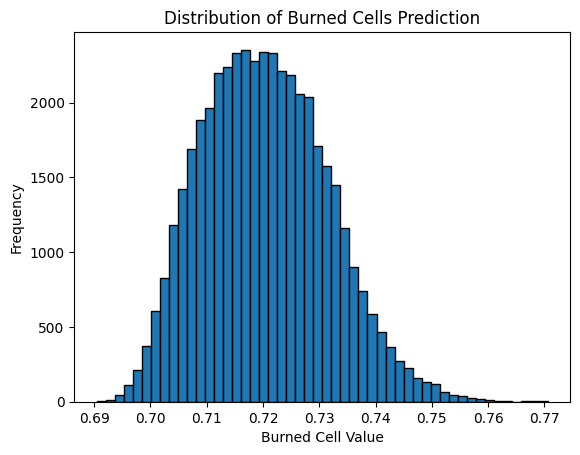

In [8]:
# plotting the distribution of burned_r
plt.hist(burned_r, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells Prediction')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.savefig("pred_dist.pdf", format='pdf')
plt.show()

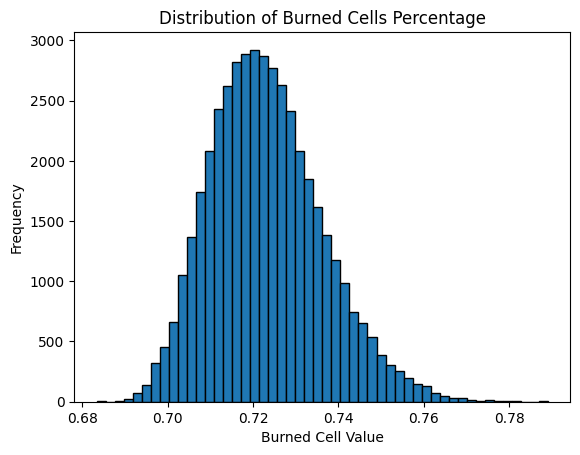

In [9]:
# plotting the distribution of burned_r
plt.hist(burned_real, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells Percentage')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.savefig("dist.pdf", format='pdf')
plt.show()

In [30]:
model.training = False

In [56]:
x, r = dataset[torch.argmax(torch.tensor(burned_real))]
mu, log_sigma = model.encode(x.unsqueeze(0))

In [57]:
x_, r_ = dataset[torch.argmin(torch.tensor(burned_real))]
mu_, log_sigma_ = model.encode(x_.unsqueeze(0))

In [51]:
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

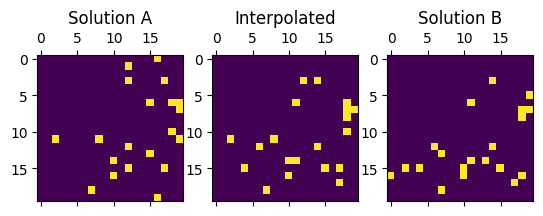

In [52]:
# Plot the original image and the sampled image and interp
plt.subplot(1, 3, 1)
plt.title('Solution A')

plt.matshow(x[0], fignum=False)

plt.subplot(1, 3, 2)
plt.title('Interpolated')
solution = model.decode(interp)[0][0]
_, indices = torch.topk(solution.flatten(), 20)
indices = np.unravel_index(indices, (20, 20))
matrix = np.zeros((20, 20))
matrix[indices] = 1
plt.matshow(matrix, fignum=False)

plt.subplot(1, 3, 3)
plt.title('Solution B')
plt.matshow(x_[0], fignum=False)
plt.savefig("interpolation_recon.pdf", format='pdf')
plt.show()


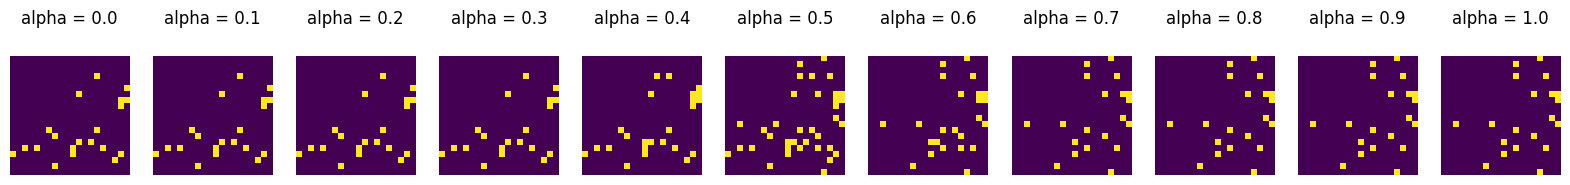

In [ ]:
# Create a figure with 11 subplots with different values of alpha from 0 to one
fig, axs = plt.subplots(1, 11, figsize=(20, 2))

for i, ax in enumerate(axs):
    alpha = i / 10
    interp = alpha * mu + (1 - alpha) * mu_
    ax.matshow(model.decode(interp)[0][0] >= 0.5)
    ax.axis('off')
    ax.set_title(f'alpha = {alpha}')

In [73]:
# Now plot the progression from alpha = 0 to alpha = 1, considering the second output of the decoder
per = []
values = []
for i in range(11):
    alpha = i / 10
    interp = alpha * mu + (1 - alpha) * mu_
    a = model.predict_burned(interp)
    sol = model.decode(interp)
    fitness = calc_fitness(model, interp.unsqueeze(0))
    values.append(fitness)
    per.append(a.item())

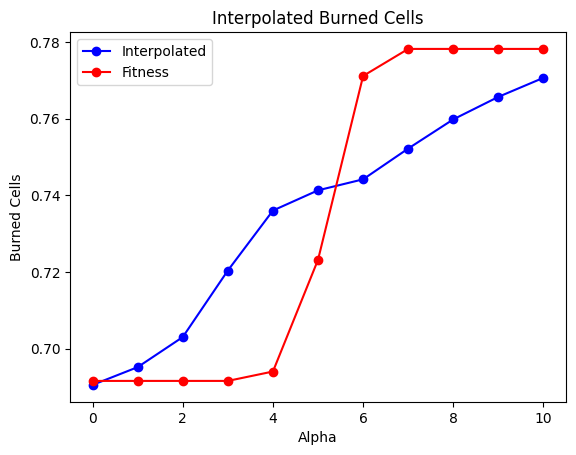

In [74]:

# add starts on the points
plt.plot(per, label='Interpolated', color='blue', marker='o')
plt.plot(values, label='Fitness', color='red', marker='o')
plt.legend()
plt.title('Interpolated Burned Cells')
plt.xlabel('Alpha')
plt.ylabel('Burned Cells')
plt.savefig("interpolation_fitness.pdf", format='pdf')
plt.show()

## Intervention

In [86]:
x, r = train_dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x_, r_ = train_dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x_.unsqueeze(0))


noise_size = 1e-5
step = 1
n_steps = 40
n_reps = 10
# Compute direction between max and min
direction = mu - mu_
direction /= torch.norm(direction)
# Generate very small gaussian noise of the same size as mu
noise = torch.randn_like(mu) * noise_size
walks = np.zeros((n_reps, n_steps, 2))
fitnesses = np.zeros((n_reps, n_steps))
pred_fitnesses = np.zeros((n_reps, n_steps))
with torch.no_grad():
    for j in tqdm(range(n_reps)):
        # pick a random point in the val set
        i = random.randint(0, len(train_dataset))
        x, r = train_dataset[i]
        start_mu, _ = model.encode(x.unsqueeze(0))
        for i in range(n_steps):
            perturbation = torch.zeros_like(start_mu)
            perturbation[:, 128:] = start_mu[:, 128:] + i * direction[:, 128:] * step # + noise * (i > 0)
            #map_perturbation = reducer.transform(perturbation)
            #walks[j, i] = map_perturbation
            fitness = calc_fitness(model, perturbation.unsqueeze(0))
            pred_fitness = model.predict_burned(perturbation)
            pred_fitnesses[j, i] = pred_fitness
            fitnesses[j, i] = fitness

100%|██████████| 10/10 [04:40<00:00, 28.02s/it]


In [90]:
# Get the mean and std of the fitnesses
mean_fitness = np.mean(fitnesses, axis=0)
std_fitness = np.std(fitnesses, axis=0)

In [91]:
# Get the mean and std of the fitnesses
pred_mean_fitness = np.mean(pred_fitnesses, axis=0)
pred_std_fitness = np.std(pred_fitnesses, axis=0)

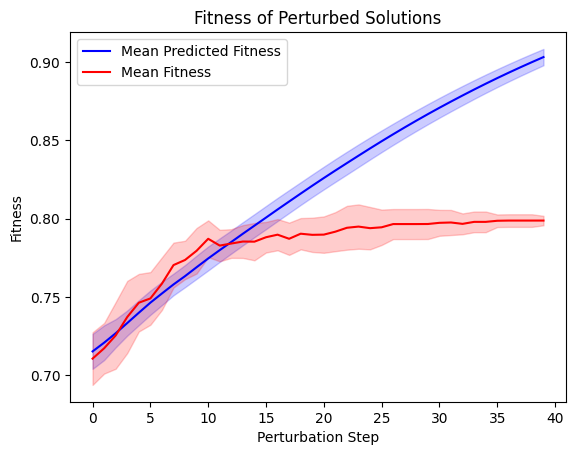

In [92]:
# Plot mean and std fitnesses
plt.plot(pred_mean_fitness, label='Mean Predicted Fitness', color='blue')
plt.fill_between(range(n_steps), pred_mean_fitness - pred_std_fitness, pred_mean_fitness + pred_std_fitness, color='blue', alpha=0.2)
plt.plot(mean_fitness, label='Mean Fitness', color='red')
plt.fill_between(range(n_steps), mean_fitness - std_fitness, mean_fitness + std_fitness, color='red', alpha=0.2)
plt.title('Fitness of Perturbed Solutions')
plt.xlabel('Perturbation Step')
plt.ylabel('Fitness')
plt.legend()
plt.savefig("max_dir.pdf", format='pdf')
plt.show()



In [ ]:
noise_size = 1e-5
step = 1
n_steps = 100
n_reps = 10
fitnesses = np.zeros((n_reps, n_steps))
losses = np.zeros((n_reps, n_steps))
for j in tqdm(range(n_reps)):
    # pick a random point in the val set
    i = random.randint(0, len(train_dataset))
    x, r = train_dataset[i]
    mu, _ = model.encode(x.unsqueeze(0))
    max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)
    latent_fixed = torch.randn(1, 128)
    latent = max_data
    latent.requires_grad = True
    optimizer = torch.optim.Adam([latent], lr=1e-1)
    for i in range(n_steps):
        full_latent = torch.cat([latent_fixed, latent], dim=1)
        #latents.append(full_latent)
        optimizer.zero_grad()
        loss = -model.predict_burned(full_latent)
        loss.backward()
        optimizer.step()
        #losses.append(loss.item())
        fitness = calc_fitness(model, full_latent.unsqueeze(0), n_sims=10)
        fitnesses[j, i] = fitness
        losses[j, i] = loss.item()

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_284763/2086710128.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)
100%|██████████| 10/10 [02:53<00:00, 17.36s/it]


In [25]:
# Get the mean and std of the fitnesses
mean_fitness = np.mean(fitnesses, axis=0)
std_fitness = np.std(fitnesses, axis=0)
mean_losses = np.mean(losses, axis=0)
std_losses = np.std(losses, axis=0)

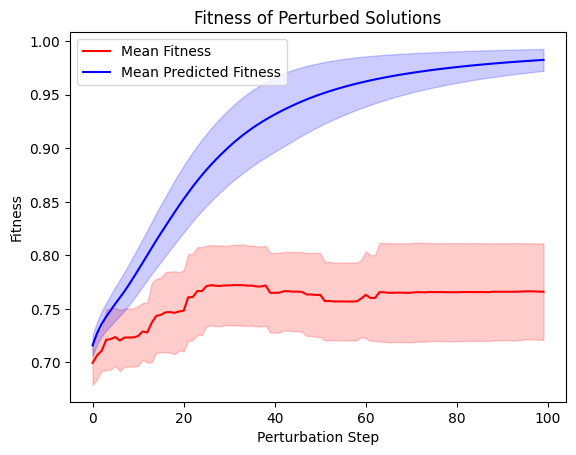

In [30]:
# Plot mean and std fitnesses
plt.plot(mean_fitness, label='Mean Fitness', color='red')
plt.fill_between(range(n_steps), mean_fitness - std_fitness, mean_fitness + std_fitness, color='red', alpha=0.2)
plt.plot(-mean_losses, label='Mean Predicted Fitness', color='blue')
plt.fill_between(range(n_steps), -mean_losses - std_losses, -mean_losses + std_losses, color='blue', alpha=0.2)
plt.title('Fitness of Perturbed Solutions')
plt.xlabel('Perturbation Step')
plt.ylabel('Fitness')
plt.legend()
plt.savefig("gradient_descent.pdf", format='pdf')
plt.show()



## Conditional Generation

In [ ]:
# conditional generation over 1000 steps
n_samples = 1000
dist = []
dist_real = []
for _ in tqdm(range(n_samples)):
    z = torch.randn(1,256)
    y = model.predict_burned(z)
    dist.append(y.item())
    dist_real.append(calc_fitness(model, z.unsqueeze(0)))

100%|██████████| 1000/1000 [13:39<00:00,  1.22it/s]


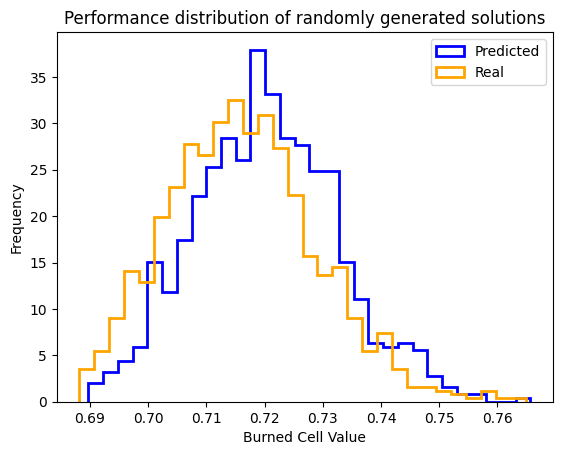

In [ ]:
plt.hist(dist, bins=30, density=True, histtype='step', label='Predicted', color='blue', linewidth=2)
plt.hist(dist_real, bins=30, density=True, histtype='step', label='Real', color='orange', linewidth=2)
plt.title('Performance distribution of randomly generated solutions')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# plot the distribution of values when the threshold is over 0.75
threshold = [0.75, 0.76, 0.77]
res = {}
for i in threshold:
    res[i] = ([], [])
dist_real_3 = []
n_samples = 1000
for i in threshold:
    for _ in tqdm(range(n_samples)):
        z = torch.randn(1,256)
        y = model.predict_burned(z)
        while y < i:
            z = torch.randn(1,256)
            y = model.predict_burned(z)
        res[i][0].append(y.item())
        res[i][1].append(calc_fitness(model, z.unsqueeze(0)))

 12%|█▏        | 117/1000 [04:46<37:43,  2.56s/it] 

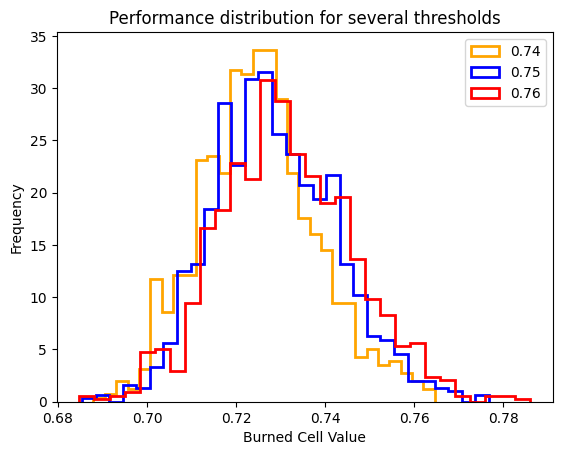

In [ ]:
plt.hist(res[0.74][1], bins=30, density=True, histtype='step', label='0.74', color='orange', linewidth=2)
plt.hist(res[0.75][1], bins=30, density=True, histtype='step', label='0.75', color='blue', linewidth=2)
plt.hist(res[0.76][1], bins=30, density=True, histtype='step', label='0.76', color='red', linewidth=2)
plt.title('Performance distribution for several thresholds')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()